# Set up workspace

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from eofs.xarray import Eof 

In [2]:
import cftime
import scipy

In [3]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils')

import make_multisimulation_dataset

In [4]:
from load_ensembles import *
import quick_map

In [5]:
import make_multisimulation_dataset

# Load data

### Define variables to load

In [6]:
var='calculated_PRECT'
domain='lnd'
ensemble='coupled'

In [7]:
end_spinup=40

In [8]:
var2='TSKIN'
domain2='lnd'

### Load full ensemble data

In [9]:
if ensemble=='coupled':
    ensemble_coupled = load_coupled_ensemble(var=var, domain=domain, printon=False)
elif ensemble=='offline':
    ensemble_coupled = load_offline_ensemble(var=var, domain=domain, printon=False)

/glade/u/home/czarakas/coupled_PPE/code/utils/load_ensembles.py:46: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fpath)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [10]:
if ensemble=='coupled':
    ensemble_coupled2 = load_coupled_ensemble(var=var2, domain=domain2, printon=False)
elif ensemble=='offline':
    ensemble_coupled2 = load_offline_ensemble(var=var2, domain=domain2, printon=False)

In [11]:
if ensemble=='offline':
    ensemble_path='offline_simulations'
    refcase_id='OFFL0000_PI_v02'
elif ensemble=='coupled':
    ensemble_path='coupled_simulations'
    refcase_id='COUP0000_PI_SOM'
if domain=='atm':
    domain_suffix='.cam.h0.'
elif domain=='lnd':
    domain_suffix='.clm2.h0.'
    
basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/'+ensemble_path+'/'+
                                 refcase_id+'/'+domain+'/proc/tseries/'+refcase_id+domain_suffix+'timeseries.'+var+'.nc')
ref_tseries=basecase_lnd[var][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')

basecase_lnd2=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/'+ensemble_path+'/'+
                                 refcase_id+'/'+domain+'/proc/tseries/'+refcase_id+domain_suffix+'timeseries.'+var2+'.nc')
ref_tseries2=basecase_lnd2[var2][end_spinup*12:,:,:].groupby('time.year').mean(dim='time')

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [12]:
from load_gridcell_areas import *

### Define function for calculating annual averages based on days per year

In [13]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
    return month_length

In [14]:
ds=basecase_lnd
month_length = xr.DataArray(get_dpm(ds.time.to_index(),
                                      calendar='noleap'),
                              coords=[ds.time], name='month_length')

numyears=np.size(ds.time.groupby('time.year').mean(dim='time').year)

In [15]:
# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()

# Test that the sum of the weights for each season is 1.0
#weights.groupby('time.month').sum().values
np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))

# Calculate the weighted average
ds_weighted = (ds[var] * weights).groupby('time.year').sum(dim='time')

In [16]:
def calculate_annual_timeseries(ds, var=var, season='Annual',
                               end_spinup=0):
    month_length = xr.DataArray(get_dpm(ds.time.to_index(),
                                      calendar='noleap'),
                              coords=[ds.time], name='month_length')
    
    numyears=np.size(ds.time.groupby('time.year').mean(dim='time'))
    
    if season=='Annual':
        weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()
        
        # Test that the sum of the weights for each year is 1.0
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))
    
        # Calculate the weighted average
        ds_weighted = (ds[var] * weights).groupby('time.year').sum(dim='time')
        
        this_ensemble_tseries=ds_weighted[end_spinup:,:,:]
    else:
        months_filtered = month_length.where(month_length['time.season']==season)
        weights = months_filtered.groupby('time.year') / months_filtered.astype(float).groupby('time.year').sum()
        
        # Test that the sum of the weights for each season is 1.0
        np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(numyears))
        
        ds_weighted = (ds[var] * weights).groupby('time.year').sum(dim='time')
        this_ensemble_tseries=ds_weighted[end_spinup:,:,:]
        
    return this_ensemble_tseries
    

### Check ensemble

In [17]:
ensemble_coupled[-1]=ensemble_coupled[-1].sel(time=slice('0049-01-16', '0188-12-16'))
ensemble_coupled2[-1]=ensemble_coupled2[-1].sel(time=slice('0049-01-16', '0188-12-16'))

In [18]:
expected_start_time=cftime.DatetimeNoLeap(49,1,16,12)
expected_end_time=cftime.DatetimeNoLeap(188,12,16,12)
for i,ds in enumerate(ensemble_coupled):
    #print(i)
    #print(ds.case_id)
    if np.size(ds.time)!=1680:
        print(ds.case_id)
        print('!!!!! Time size is wrong dimension')
    if ds.time.values[0] != expected_start_time:
        print(ds.time.values[0])
    if ds.time.values[-1] != expected_end_time:
        print(ds.time.values[-1])
    #print('----------')

# Make datasets with all data

In [19]:
# Define grid for dataset
ds_grid = ensemble_coupled[0]

# Make precipitation dataset
var_array_PRECT_1time = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

var_array_PRECT=var_array_PRECT_1time.expand_dims({"time": ds_grid.time[end_spinup*12:]},axis=0).copy()

# Make temperature dataset
var_array_TS_1time = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

var_array_TS=var_array_TS_1time.expand_dims({"time": ds_grid.time[end_spinup*12:]},axis=0).copy()

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [20]:
# Put data in temperature dataset
for i, ds2 in enumerate(ensemble_coupled2):
    print(i)
    var_array_TS[:,:,:,i]=ds2[var2][end_spinup*12:,:,:]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [21]:
# Put data in precip dataset
for i, ds in enumerate(ensemble_coupled):
    print(i)
    var_array_PRECT[:,:,:,i]=ds[var][end_spinup*12:,:,:]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [22]:
# Save precipitation dataset
var_array_PRECT.to_netcdf('PRECT_delta.nc')

In [19]:
var_array_PRECT=xr.open_dataset('data/PRECT_delta_Annual.nc')

In [23]:
ref_land_TS=calculate_annual_timeseries(var_array_TS.to_dataset(name=var2),var=var2,season='Annual')
Ts_tseries=calculate_annual_timeseries(basecase_lnd2,var=var2,season='Annual')
delta_land_Ts=((Ts_tseries.mean(dim='year')*landweights).mean(dim=['lat','lon'])-
               (ref_land_TS.mean(dim='year')*landweights).mean(dim=['lat','lon']))

In [24]:
ref_land_PRECT=calculate_annual_timeseries(var_array_PRECT.to_dataset(name=var),var=var,season='Annual')
PRECT_tseries=calculate_annual_timeseries(basecase_lnd,var=var,season='Annual')

delta_land_PRECT=((PRECT_tseries.mean(dim='year')*landweights).mean(dim=['lat','lon'])-
               (ref_land_PRECT.mean(dim='year')*landweights).mean(dim=['lat','lon']))

In [54]:
data_descriptions=[]
for i, ds in enumerate(ensemble_coupled):
    print(ds.case_id)
    desc=crosswalk.description.values[crosswalk.key_coupledPPE.values==ds.case_id[0:8]][0]
    data_descriptions.append(desc)

COUP0001_PI_SOM_v02
COUP0037_PI_SOM_v02
COUP0007_PI_SOM_v02
COUP0008_PI_SOM_v02
COUP0009_PI_SOM_v02
COUP0010_PI_SOM_v02
COUP0013_PI_SOM_v02
COUP0014_PI_SOM_v02
COUP0015_PI_SOM_v02
COUP0016_PI_SOM_v02
COUP0017_PI_SOM_v02
COUP0018_PI_SOM_v02
COUP0019_PI_SOM_v02
COUP0020_PI_SOM_v02
COUP0021_PI_SOM_v02
COUP0022_PI_SOM_v02
COUP0023_PI_SOM_v02
COUP0024_PI_SOM_v02
COUP0025_PI_SOM_v02
COUP0026_PI_SOM_v02
COUP0027_PI_SOM_v02
COUP0028_PI_SOM_v02
COUP0029_PI_SOM_v02
COUP0030_PI_SOM_v02
COUP0031_PI_SOM_v02
COUP0032_PI_SOM_v02
COUP0033_PI_SOM_v02
COUP0034_PI_SOM_v02
COUP0035_PI_SOM_v02
COUP0036_PI_SOM_v02
COUP0003_PI_SOM_v02
COUP0004_PI_SOM_v02
COUP0005_PI_SOM_v02
COUP0006_PI_SOM_v02
COUP0011_PI_SOM_v02
COUP0012_PI_SOM_v02


# Test significance of changes
* Student's t test
* Walker's test for field significance
* False discovery rate

In [172]:
season='Annual'#'Annual','DJF,'MAM','JJA','SON'

In [173]:
ds_grid = ensemble_coupled[0]

var_array_ttest = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)
var_array_pval = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Calculate where changes are significant

In [174]:
ref_tseries=calculate_annual_timeseries(basecase_lnd,season=season)
for i, ds in enumerate(ensemble_coupled):
    ds_annual=calculate_annual_timeseries(ds, var=var, season=season)
    [tstat, pval] = scipy.stats.ttest_ind(ref_tseries, ds_annual, equal_var=False)#, alternative='two-sided')
    diff=ds_annual.mean(dim='year')-ref_tseries.mean(dim='year')
    var_array_ttest[:,:,i]=tstat
    var_array_pval[:,:,i]=pval

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/glade/u/home/czarakas/.conda/envs/E

In [175]:
var_array_pval.to_netcdf('data/PRECT_pval_'+season+'.nc')

### Calculate field significance

In [30]:
# Walker's test
flat_array=var_array_pval[:,:,0].values.flatten()
flat_array_nonan=flat_array[~np.isnan(flat_array)]
K=np.size(flat_array_nonan)
alpha_global=0.05
p_walker=1-((1-alpha_global)**(1/K))

In [31]:
walker_test=(var_array_pval<=p_walker).sum(dim=['lat','lon']).values

In [32]:
Walker_test=[]
for i, w in enumerate(walker_test):
    if w>0:
        Walker_test.append('*')
    else:
        Walker_test.append('')

In [33]:
var_array_sigmask = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)
for i in np.arange(0,36):
    print('------------')
    print(i)
    in_array=var_array_pval[:,:,i].values.flatten()
    in_array=in_array[~np.isnan(in_array)]
    out_array=np.argsort(in_array)
    sorted_array=in_array[out_array]
    j = np.arange(0, K)+1
    inds=(sorted_array<=(alpha_global*(j/K)))
    if np.sum(inds)>0:
        jmax=np.nanmax(j[inds])-1
        print(jmax)
        pmax=sorted_array[jmax]
        print(pmax)
        var_array_sigmask[:,:,i]=(var_array_pval[:,:,i]<=pmax)

------------
0
10
9.056536263997188e-05
------------
1
11
0.00010304419120163284
------------
2
52
0.00046086955889257077
------------
3
2021
0.017762928146055273
------------
4
2508
0.022093155232943123
------------
5
116
0.0010005070573015453
------------
6
802
0.007041881474328667
------------
7
600
0.005231023917331853
------------
8
1672
0.01474748678960781
------------
9
52
0.0004644319434601733
------------
10
0
4.9460269204572114e-06
------------
11
------------
12
843
0.007386887698787217
------------
13
------------
14
190
0.001643304277658589
------------
15
------------
16
213
0.001849663496963638
------------
17
830
0.007129352372371562
------------
18
38
0.00029539213824126653
------------
19
1321
0.011659752471128899
------------
20
289
0.0025489520447532265
------------
21
1195
0.010541216895407643
------------
22
158
0.0013237040865674069
------------
23
214
0.001892157410033015
------------
24
------------
25
688
0.006040536780170686
------------
26
609
0.005372885312

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Print info about statistical significance

In [34]:
for i in walker_test:
    print(i>0)

True
True
True
True
True
True
True
True
True
True
True
False
True
False
True
False
True
True
True
True
True
True
True
True
False
True
True
True
False
False
False
False
True
True
True
True


In [35]:
for i, ds in enumerate(ensemble_coupled):
    #print(i)
    print(crosswalk.minmax.values[(crosswalk.key_coupledPPE==ds.case_id[0:8]).values][0])

min
max
min
max
min
max
min
max
min
max
min
max
max
min
min
max
max
min
max
min
max
min
max
min
max
min
min
max
min
max
min
max
min
max
min
max


In [36]:
frac_changed_land_pct=[]
for i, ds in enumerate(ensemble_coupled):
    print(i)
    print(ds.case_id)
    print(crosswalk.description.values[(crosswalk.key_coupledPPE==ds.case_id[0:8]).values][0])
    pval=var_array_pval[:,:,i]
    sig_mask=(pval<=0.05)
    frac_changed=(sig_mask*landweights).mean(dim=['lat','lon'])
    frac_changed_land_pct.append(frac_changed.values)
    print(frac_changed.values)
    print('-----------')

0
COUP0001_PI_SOM_v02
rhosnir, min
0.15139832
-----------
1
COUP0037_PI_SOM_v02
rhosnir, max
0.13499787
-----------
2
COUP0007_PI_SOM_v02
d_max, min
0.15938137
-----------
3
COUP0008_PI_SOM_v02
d_max, max
0.46834618
-----------
4
COUP0009_PI_SOM_v02
frac_sat_soil_dsl_init, min
0.52337503
-----------
5
COUP0010_PI_SOM_v02
frac_sat_soil_dsl_init, max
0.13950394
-----------
6
COUP0013_PI_SOM_v02
maximum_leaf_wetted_fraction, min
0.3708214
-----------
7
COUP0014_PI_SOM_v02
maximum_leaf_wetted_fraction, max
0.25804815
-----------
8
COUP0015_PI_SOM_v02
fff, min
0.51113576
-----------
9
COUP0016_PI_SOM_v02
fff, max
0.13779971
-----------
10
COUP0017_PI_SOM_v02
upplim_destruct_metamorph, min
0.07915851
-----------
11
COUP0018_PI_SOM_v02
upplim_destruct_metamorph, max
0.08034436
-----------
12
COUP0019_PI_SOM_v02
medlynslope, max
0.3252813
-----------
13
COUP0020_PI_SOM_v02
medlynintercept, min
0.049212266
-----------
14
COUP0021_PI_SOM_v02
tpu25ratio, min
0.17339692
-----------
15
COUP0022_PI_

# Map of changes

### Calculate mean changes

In [176]:
unitconv=86400

# Calculate timeseries of years
var_array=calculate_annual_timeseries(var_array_PRECT.to_dataset(name='PRECT'), 
                                      var='PRECT',
                                      season=season)
ref_tseries=calculate_annual_timeseries(basecase_lnd,
                                        season=season, end_spinup=60).mean(dim='year')

# Average over time
var_array_avg=var_array.mean(dim='year')

# Calculate difference from reference simulation
var_array_avg_delta=(var_array_avg*unitconv)-(ref_tseries*unitconv)

# Calculate percentage change
var_array_avg_delta_pct=var_array_avg_delta*100/(ref_tseries*unitconv)

var_range_pct=((var_array_avg_delta_pct.quantile(0.95, dim='ensemble_key'))-
           (var_array_avg_delta_pct.quantile(0.05, dim='ensemble_key')))

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


In [177]:
var_array_avg_delta.to_netcdf('data/PRECT_delta_'+season+'.nc')
var_array_avg_delta_pct.to_netcdf('data/PRECT_delta_pct_'+season+'.nc')

# Define mapping functions

In [65]:
def quick_map_subplot_contour(mapdata_for_subplot, lat, lon, nrow=3, ncol=3, ind=1, title=None,
              cmap=None, clim=None, sigmask=None,plot_cbar=False):
    """ Creates map """
    ax = plt.subplot(nrow, ncol, ind+1, projection=ccrs.Robinson())
    ax.coastlines(resolution='110m') #learn how to add resolution here??
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata_for_subplot, coord=lon)

    cs = plt.contourf(cyclic_lons, lat, cyclic_data,
                            transform=ccrs.PlateCarree(), extend='both',levels=np.linspace(clim[0],clim[1],11),
                     add_colorbar=False)

    if sigmask is not None:
        cyclic_data_mask, cyclic_lons_mask = add_cyclic_point(sigmask, coord=lon)
        ax.contourf(
            cyclic_lons_mask, lat, cyclic_data_mask,
            transform=ccrs.PlateCarree(),
            colors='none',
            levels=[0.5, 1.5],
            hatches=['///'])
        
    # Choose your colormap
    if cmap:
        plt.set_cmap(cmap)
    else:
        plt.set_cmap(plt.cm.viridis)

    ax.patch.set_alpha(1.0)
    
    if title is not None: plt.title(title, fontsize=16)

    if clim:
        plt.clim(clim)
        cs.set_clim(clim[0], clim[1])
        cs.set_clim(clim)
    
    if plot_cbar:
        cbar = plt.colorbar(ax=ax, orientation='horizontal',
                                extend='both', pad=.02, shrink=0.9)
        cbar.ax.tick_params(labelsize=14)

        if clim:
            cbar.set_clim(clim)

In [38]:
def plot_map(mapdata, sigmask=None, 
             vmin=0, vmax=30, nlev=2.5,
            filename=None):
    fig = plt.figure(figsize=(10,6))
    ax = plt.axes(projection=ccrs.Robinson())#projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_global()
    
    cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)
    
    plt.contourf(cyclic_lons, mapdata.lat, #contourf
                   cyclic_data, 
                   levels=np.arange(0, vmax+nlev, nlev), cmap=plt.cm.inferno,#, #levels=np.arange(-100,100),
                   transform=ccrs.PlateCarree(), extend='both')
    
    plt.colorbar(extend='both', orientation='horizontal', ticks=np.arange(0, vmax+nlev, nlev))
    
    if sigmask is not None:
        cyclic_data_mask, cyclic_lons_mask = add_cyclic_point(sigmask, coord=sigmask.lon)
        plt.contourf(
            cyclic_lons_mask, sigmask.lat, cyclic_data_mask,
            transform=ccrs.PlateCarree(),
            colors='none',
            levels=[0.5, 1.5],
            hatches=['///'])
        
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)

# Map of all changes

In [61]:
crosswalk_descriptions_short=['rhosnir, min', 'rhosnir, max', 'd_max, min', 'd_max, max',
       'frac_sat_soil_..., min', 'frac_sat_soil_..., max',
       'maximum_leaf_wet..., min',
       'maximum_leaf_wet..., max', 'fff, min', 'fff, max',
       'upplim_destruct_..., min', 'upplim_destruct_..., max',
       'medlynslope, max', 'medlynintercept, min', 'tpu25ratio, min',
       'tpu25ratio, max', 'jmaxb0, max', 'jmaxb1, min', 'jmaxb1, max',
       'kmax, min', 'kmax, max', 'nstem, min', 'nstem, max', 'lmrha, min',
       'lmrha, max', 'medlynslope, min', 'jmaxb0, min',
       'medlynintercept, max', 'sand_pf, min', 'sand_pf, max',
       'z0mr, min', 'z0mr, max', 'zsno, min', 'zsno, max',
       'zetamaxstable, min', 'zetamaxstable, max']

# This is to reorder the ensemble members so parameters are next to each other
int_list=[0,1,2,3,4,5,
          8,9,28,29,6,7,
          25,12,13,27,19,20,
          14,15,26,16,17,18,
          23,24,21,22,10,11,
          32,33,30,31,34,35]

In [45]:
mapdata=var_array_avg_delta_pct#var_array_avg_delta
sigmask_data1=var_array_pval<=0.05
sigmask_data=np.abs(var_array_sigmask-1)


In [ ]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,20))
for j,i in enumerate(int_list):
    plt.subplot(6,6,j+1)
    mapdata_for_subplot=mapdata[:,:,i].where(landweights>0)
    sigmask=var_array_pval[:,:,i]>0.05

    title=crosswalk_descriptions_short[i]+' ('+str(np.round(frac_changed_land_pct[i]*100))+'% '+Walker_test[i]+')'
    if i<40:
        quick_map_subplot_contour(mapdata_for_subplot, 
                                mapdata_for_subplot.lat, 
                                mapdata_for_subplot.lon, nrow=6, ncol=6, ind=j,
                               cmap=plt.cm.BrBG, clim=[-20,20],title=title,
                     sigmask=sigmask)
    else:
        quick_map_subplot_contour(mapdata_for_subplot, 
                                mapdata_for_subplot.lat, 
                                mapdata_for_subplot.lon, nrow=6, ncol=6, ind=j,
                               cmap=plt.cm.BrBG, clim=[-20,20],title=crosswalk.description.values[i],
                     sigmask=sigmask, plot_cbar=True)
    
plt.tight_layout()
plt.savefig('Global_'+var+'_maps_'+ensemble+'_'+season+'.png')

In [100]:
decrease_precip=((var_array_avg_delta<0)&(var_array_pval<=0.05))
increase_precip=((var_array_avg_delta>0)&(var_array_pval<=0.05))

In [129]:
var_array_pval.to_netcdf('data/Annual_PRECT_pval.nc')

In [104]:
increase_precip_global=(increase_precip*landweights).mean(dim=['lat','lon'])*100
decrease_precip_global=(decrease_precip*landweights).mean(dim=['lat','lon'])*100

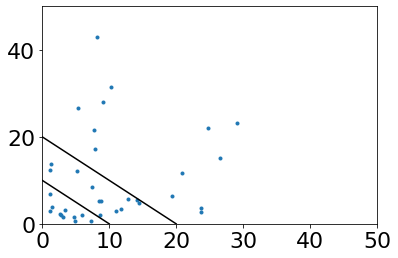

In [111]:
plt.plot(increase_precip_global, decrease_precip_global,'.')
plt.xlim([0,50])
plt.ylim([0,50])
plt.plot([0,10],[10,0],'-k')
plt.plot([0,20],[20,0],'-k')

In [126]:
landmask_flat=landweights.values.flatten()
i=3
array_flat_1ens=var_array_avg_delta[:,:,i].values.flatten()[landmask_flat>0]

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [128]:
var_array_avg_delta.to_netcdf('data/Annual_PRECT_delta.nc')

(array([  20.,   60.,  237.,  808., 3555.,  766.,  141.,   50.,   21.,
           8.]),
 array([-0.51937071, -0.40238728, -0.28540385, -0.16842042, -0.05143699,
         0.06554644,  0.18252987,  0.2995133 ,  0.41649673,  0.53348016,
         0.65046359]),
 <a list of 10 Patch objects>)

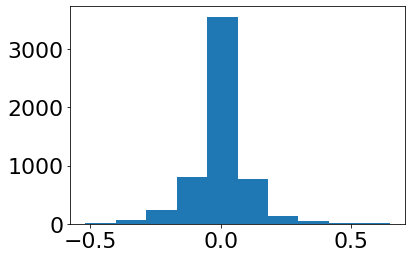

In [127]:
plt.hist(array_flat_1ens)

Text(0, 0.5, '% of land where precipitation increases by >5%')

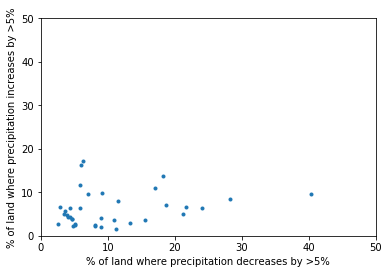

In [58]:
plt.plot(((var_array_avg_delta_pct<-5)*landweights).mean(dim=['lat','lon'])*100,
         (var_array_avg_delta_pct>5*landweights).mean(dim=['lat','lon'])*100,'.')
plt.xlim([0,50])
plt.ylim([0,50])
plt.xlabel('% of land where precipitation decreases by >5%')
plt.ylabel('% of land where precipitation increases by >5%')

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


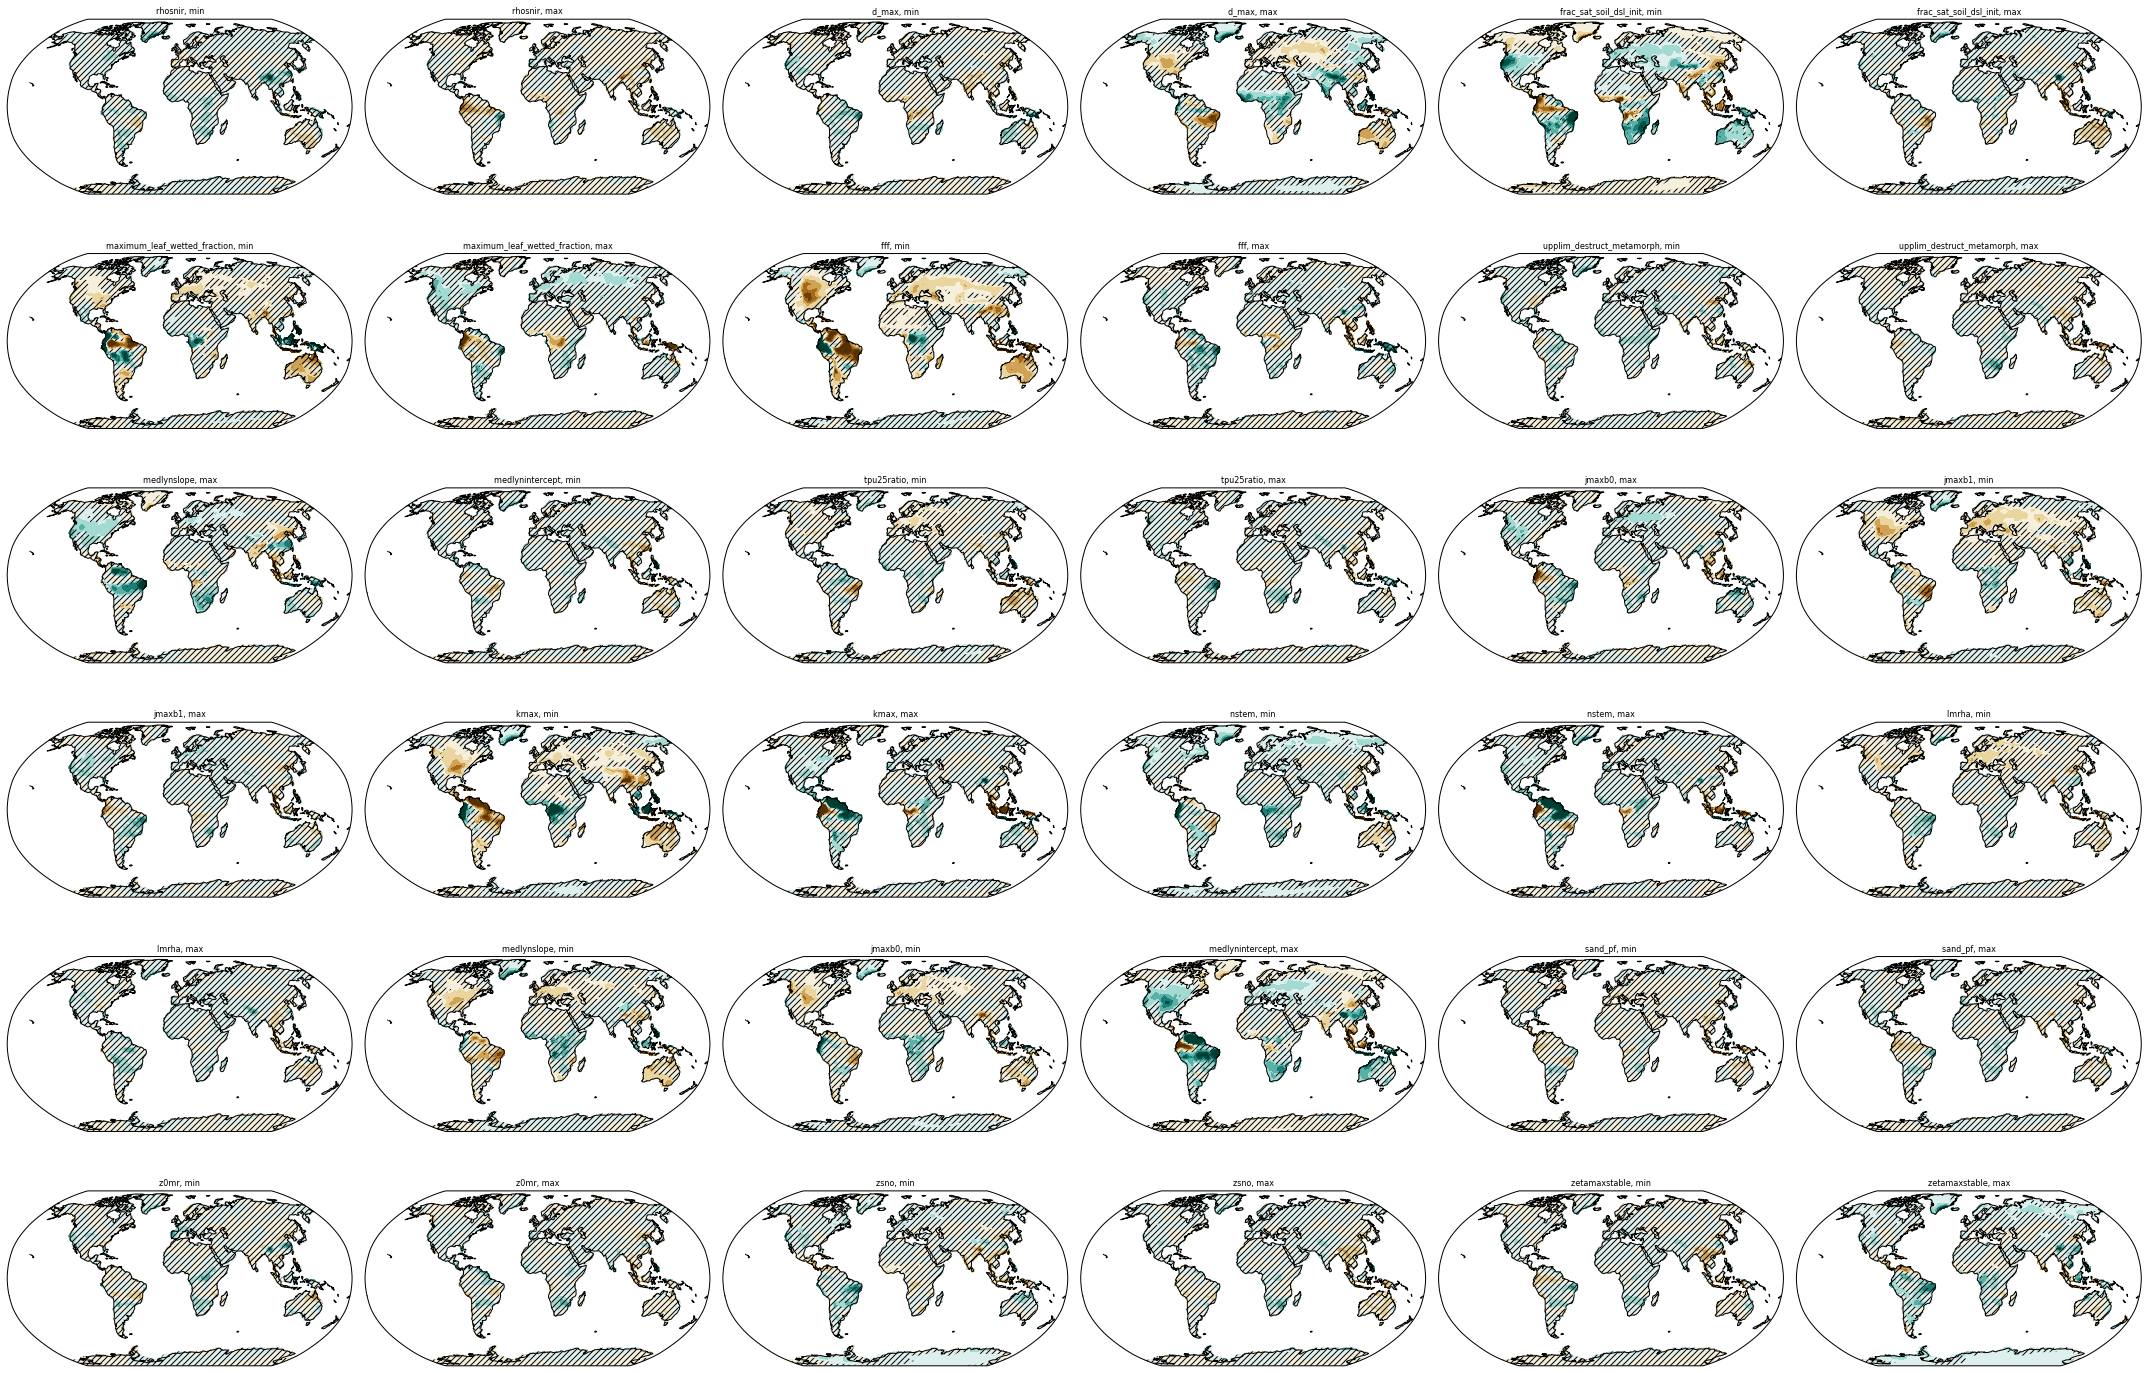

In [38]:
plt.rcParams.update({'font.size': 12})
vmin=-0.5
vmax=0.5
plt.figure(figsize=(30,20))
for i in np.arange(0,36):
    plt.subplot(6,6,i+1)
    mapdata_for_subplot=(mapdata[:,:,i]).where(landweights>0)#.where(sigmask_data1[:,:,i])
    sigmask=sigmask_data[:,:,i].where(landweights>0)#.where(sigmask_data1[:,:,i])

    if i<35:
        quick_map_subplot_contour(mapdata_for_subplot, 
                                mapdata_for_subplot.lat, 
                                mapdata_for_subplot.lon, nrow=6, ncol=6, ind=i,
                               cmap=plt.cm.BrBG, clim=[vmin,vmax],title=crosswalk.description.values[i],
                     sigmask=sigmask)
    else:
        quick_map_subplot_contour(mapdata_for_subplot, 
                                mapdata_for_subplot.lat, 
                                mapdata_for_subplot.lon, nrow=6, ncol=6, ind=i,
                               cmap=plt.cm.BrBG, clim=[vmin,vmax],title=crosswalk.description.values[i],
                     sigmask=sigmask)#, plot_cbar=True)
    
plt.tight_layout()
plt.savefig('Global_'+var+'_maps_'+ensemble+'_'+season+'.png')

In [79]:
landweights

<xarray.DataArray ()>
array(0.99999994, dtype=float32)

In [82]:
(((var_array_pval<=0.05).sum(dim='ensemble_key')>20)*landweights).mean(dim=['lat','lon'])

<xarray.DataArray ()>
array(0.0104537, dtype=float32)

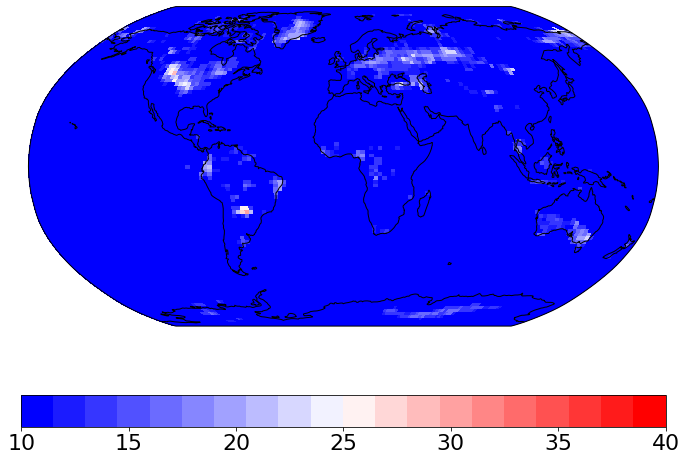

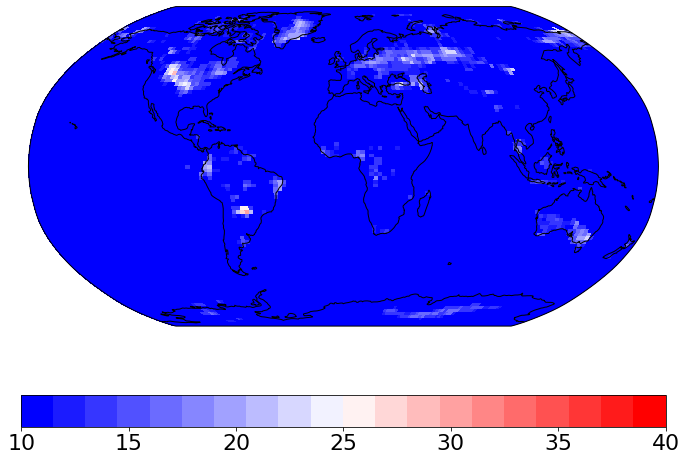

In [85]:
quick_map.quick_map((var_array_pval<=0.05).sum(dim='ensemble_key'), cmap=plt.get_cmap('bwr',20),clims=[10,40])

# Get area weights

#### Calculate area weights

In [86]:
import load_gridcell_areas

In [87]:
# area dataArray
ds_to_analyze=var_array_avg_delta[:,:,0]
da_area = area_grid(ds_to_analyze.lat, ds_to_analyze.lon)
# total area
total_area = da_area.sum(['lat','lon'])
#  weighted by grid-cell area
areaweights = (da_area) / total_area

In [88]:
if domain=='atm':
    landweights=landweights.reindex_like(areaweights, tolerance=0.05, method='nearest')

# Maps of mean changes

### Comparison to Fischer et al.

In [42]:
import matplotlib as mpl
# force the first color entry to be grey
cmaplist=['#591A8E','#BE3A29','#D3582A', '#EEBD45','#ECDF50',
          '#76BB3A','#81CB85','#85BCDB','#4A50A4']


# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, 9)

### Calculate mean changes

In [43]:
unitconv=86400
season='Annual'

var_array=calculate_annual_timeseries(var_array_PRECT.to_dataset(name='PRECT'), 
                                      var='PRECT',
                                      season=season)
ref_tseries=calculate_annual_timeseries(basecase_lnd,
                                        season=season, end_spinup=60).mean(dim='year')

var_array_avg=var_array.mean(dim='year')*unitconv

var_array_avg_delta=(var_array_avg)-(ref_tseries*unitconv)

var_array_avg_delta_pct=var_array_avg_delta*100/(ref_tseries*unitconv)

var_range_pct=((var_array_avg_delta_pct.quantile(0.95, dim='ensemble_key'))-
           (var_array_avg_delta_pct.quantile(0.05, dim='ensemble_key')))

var_pctrange=(var_array_avg.quantile(0.95, dim='ensemble_key')-
           var_array_avg.quantile(0.05, dim='ensemble_key'))

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


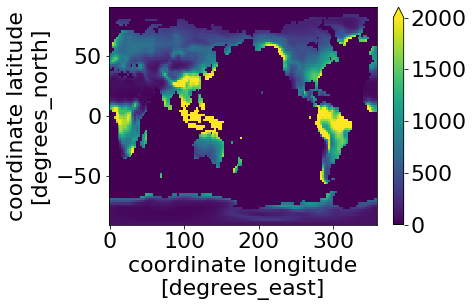

In [97]:
(ref_tseries*365*86400).plot(vmax=2000)

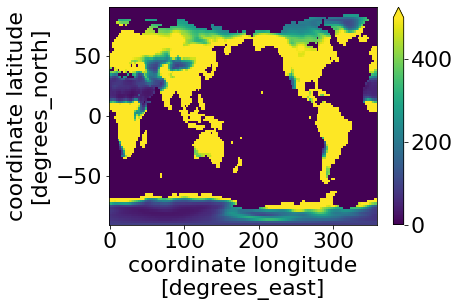

In [96]:
(ref_tseries*365*86400).plot(vmax=500)

In [44]:
# Possible filter: regions where changes are pretty much never statitsically significant
not_sig=(var_array_pval<0.05).sum(dim='ensemble_key')<=5

# Possible filter: regions with low rain in baseline
ref_tseries=calculate_annual_timeseries(basecase_lnd,
                                        season=season, end_spinup=60)
low_rain=(ref_tseries*86400*365<=200)

### Map of percent changes in precipitation

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


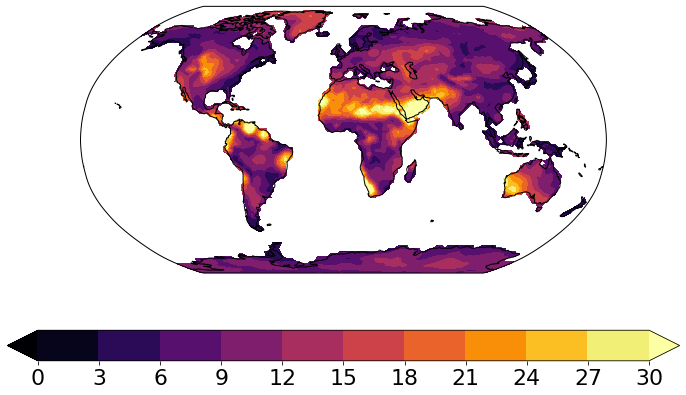

In [89]:
#### Option 1: Range as calculated by 2*sigma
mapdata=2*(var_array_avg_delta_pct.std(dim='ensemble_key'))

#### Option 2: Range as 5th to 95th percentile
mapdata=(var_array_avg_delta_pct.quantile(0.95, dim='ensemble_key')-
           var_array_avg_delta_pct.quantile(0.05, dim='ensemble_key'))

#mapdata=(var_array_avg_delta_pct.max(dim='ensemble_key')-
#           var_array_avg_delta_pct.min(dim='ensemble_key'))

plot_map(mapdata,vmax=30, nlev=3)
         #sigmask=not_sig.where(landweights>0)

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [79]:
(mapdata*landweights).mean(dim=['lat','lon'])

<xarray.DataArray ()>
array(18.15029749)

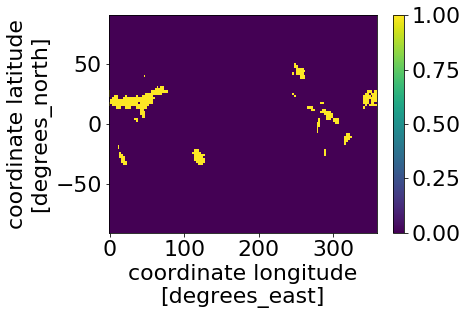

In [75]:
(mapdata>20).plot()

### Map of absolute changes in rainfall

In [87]:
global_avg_delta=(var_array_avg_delta*landweights).mean(dim=['lat','lon'])
(np.nanmax(global_avg_delta)-np.nanmin(global_avg_delta))*365

40.42765615703444

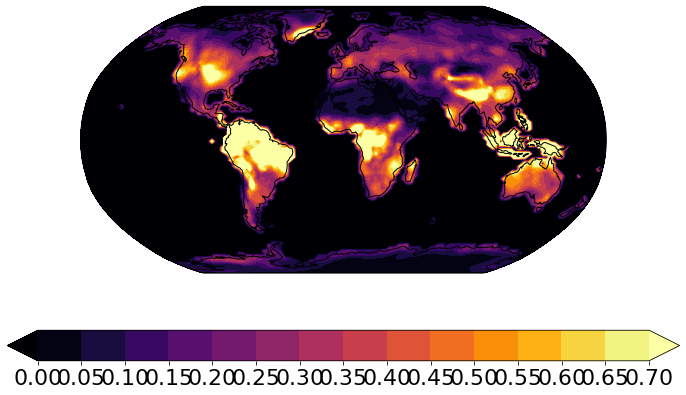

In [84]:
#### Option 1: Range as calculated by 2*sigma
mapdata=2*(var_array_avg_delta.std(dim='ensemble_key')).where(landweights>0)

#### Option 2: Range as 5th to 95th percentile
mapdata=(var_array_avg_delta.quantile(0.95, dim='ensemble_key')-
           var_array_avg_delta.quantile(0.05, dim='ensemble_key')).where(landweights>0)

mapdata=(var_array_avg_delta.max(dim='ensemble_key')-
           var_array_avg_delta.min(dim='ensemble_key'))

plot_map(mapdata,vmax=0.7, nlev=0.05)
         #sigmask=not_sig.where(landweights>0)

### Map of number of significant changes

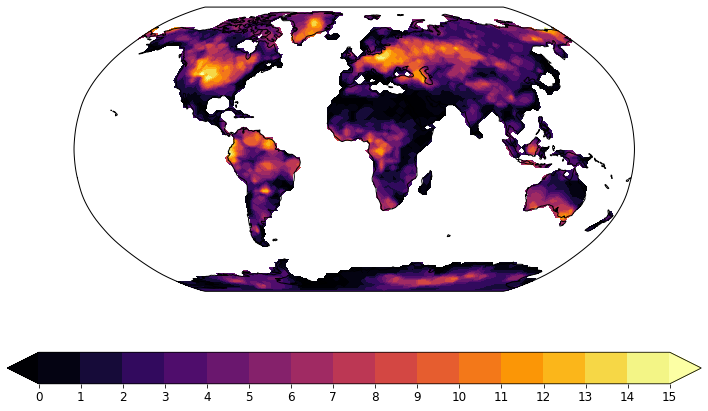

In [47]:
#### Option 1: Range as calculated by 2*sigma
mapdata=var_array_sigmask.sum(dim='ensemble_key').where(landweights>0)

plot_map(mapdata,
         sigmask=None,vmax=15, nlev=1)

# EOF analysis of changes in mean temperature

### Set up data

In [25]:
var_array=var_array_PRECT['__xarray_dataarray_variable__']#/delta_land_PRECT

In [26]:
deltaT=(var_array-var_array.mean(dim='ensemble_key'))
deltaT_global=(deltaT*landweights).mean(dim=['lat','lon'])
deltaT_normalized=deltaT#-deltaT_global

### Do EOF

In [27]:
ds_eofs = var_array#_pct_change#[:,:,0:34]
ds_eofs=ds_eofs#*86400*365*1000

In [28]:
from datetime import datetime, timedelta
num_ensembles=np.shape(ds_eofs)[2]
print(num_ensembles)
date2=datetime(2000,1,1)+timedelta(days=num_ensembles, minutes=0)
date2_str=date2.isoformat()[0:10]

36


In [29]:
# Rearrange all-model dataset for EOF
ds_eofs=ds_eofs.transpose()
ds_eofs=ds_eofs.rename({"ensemble_key": "time"})
ds_eofs['time']=np.arange('2000-01-01', date2_str, dtype='datetime64') #11
ds_eofs=ds_eofs-ds_eofs.mean(dim='time')

In [73]:
#solver = Eof(ds_eofs, weights=areaweights.transpose())
solver = Eof(ds_eofs, weights=landweights.transpose())
eofs = solver.eofs()
eofs = eofs.transpose()
pcs = solver.pcs()#pcscaling=2)

#### Check reconstruction

In [88]:
reconstructed=solver.reconstructedField(1)
reconstructed_mode0=eofs[:,:,0]*pcs[:,0]/landweights
reconstructed_mode1=eofs[:,:,1]*pcs[:,1]/landweights
reconstructed_mode2=eofs[:,:,2]*pcs[:,2]/landweights

In [75]:
diff=reconstructed_mode0[:,:,1]-reconstructed[1,:,:]
print(np.nanmax(diff))
print(np.nanmin(diff))

0.0
0.0


In [105]:
reconstructed=solver.reconstructedField(3)
reconstructed_T=reconstructed.transpose()
#reconstructed_3modes=eofs[:,:,:3]*pcs[:,:3]/landweights
reconstructed_manual=reconstructed_mode0+reconstructed_mode1+reconstructed_mode2

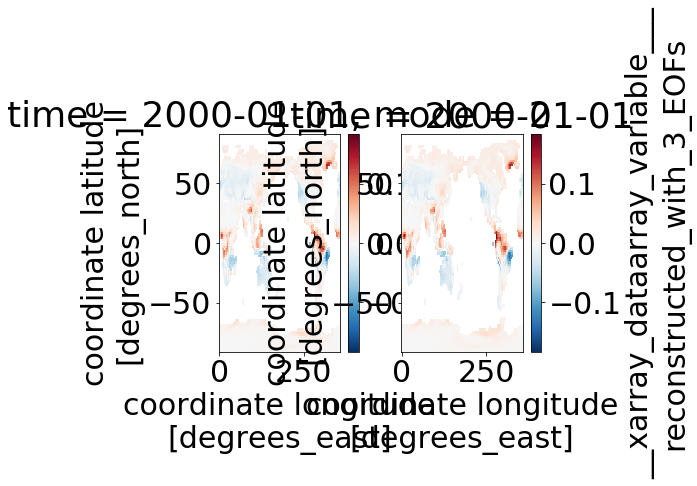

In [108]:
i=0
plt.subplot(1,2,1)
(reconstructed_manual)[:,:,0].plot()
plt.subplot(1,2,2)
(reconstructed_T)[:,:,0].plot()

In [101]:
np.shape(reconstructed_manual.values)

(96, 144, 36)

In [94]:
print(np.nanmax((reconstructed_mode0+reconstructed_mode1+reconstructed_mode2)-reconstructed))
print(np.nanmin((reconstructed_mode0+reconstructed_mode1+reconstructed_mode2)-reconstructed))

4.440892098500626e-16
-4.440892098500626e-16


## Make figures

#### Fraction of variance explained

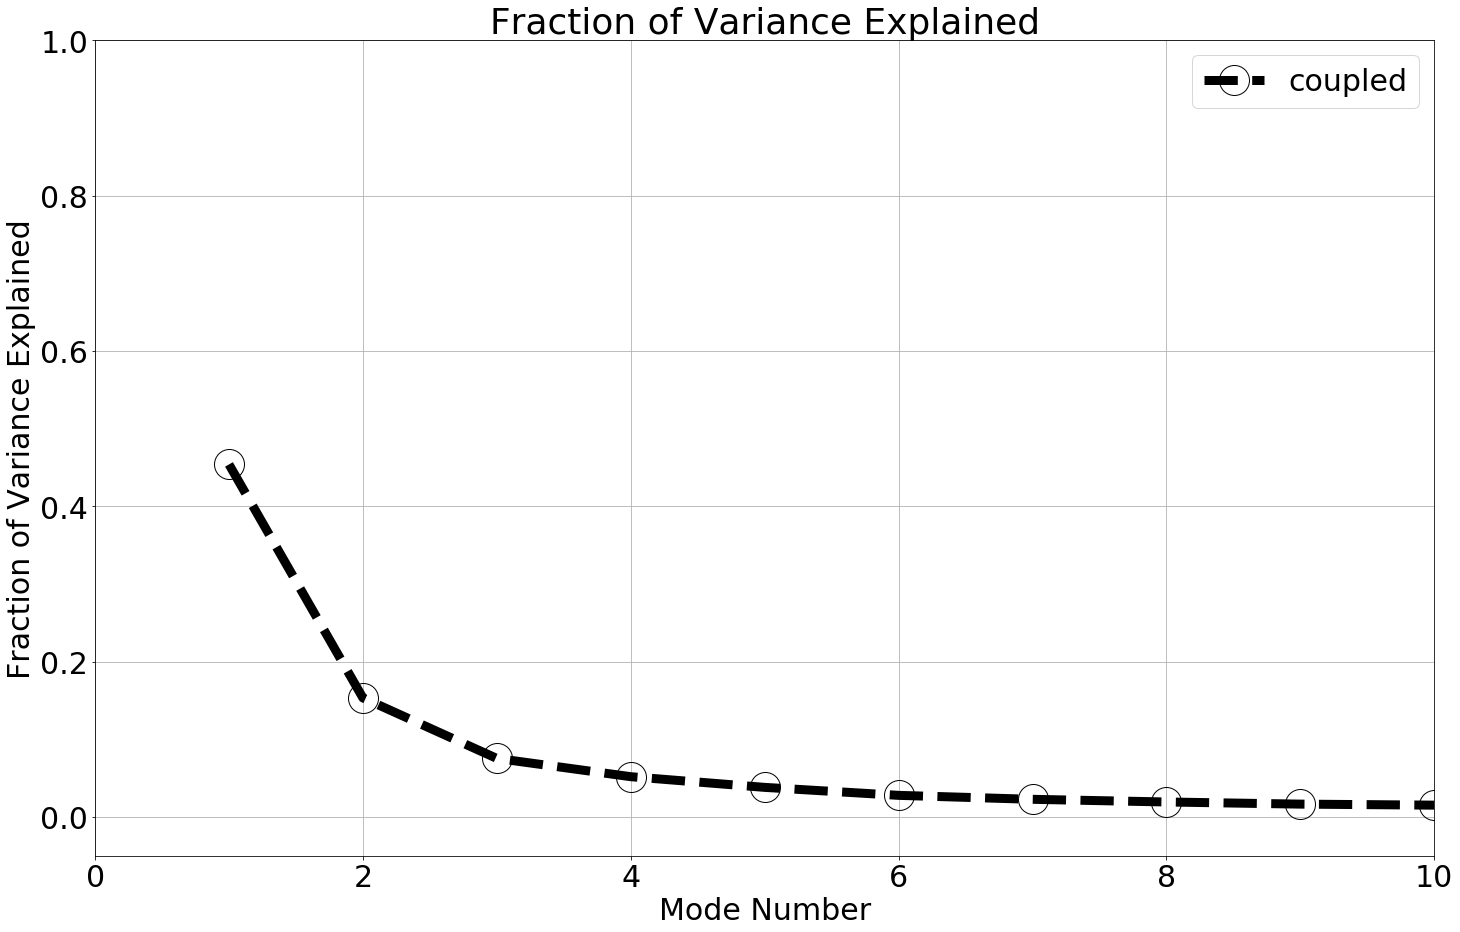

In [76]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(24,15))
plt.plot(np.arange(1,np.size(ds_eofs['time'])+1),solver.varianceFraction().values,
         'o--k', fillstyle='none',markersize=30,linewidth=9, label=ensemble)
solver.varianceFraction().values[0]+solver.varianceFraction().values[1]
plt.xlim([0,10])
plt.ylim([-0.05,1])
plt.title('Fraction of Variance Explained')
plt.xlabel('Mode Number')
plt.ylabel('Fraction of Variance Explained')
plt.grid()
plt.legend()
plt.savefig(var+'_frac_variance_explained.png')

In [77]:
for i in np.arange(0,4):
    print('EOF '+str(i+1))
    print(solver.varianceFraction().values[i])
    print(solver.varianceFraction().values[0:i+1].sum())

EOF 1
0.45397704580680465
0.45397704580680465
EOF 2
0.15331748390181874
0.6072945297086234
EOF 3
0.07538886548788054
0.6826833951965039
EOF 4
0.05187099403940462
0.7345543892359085


### Spatial patterns

In [71]:
eof1 = solver.eofsAsCovariance(neofs=1)

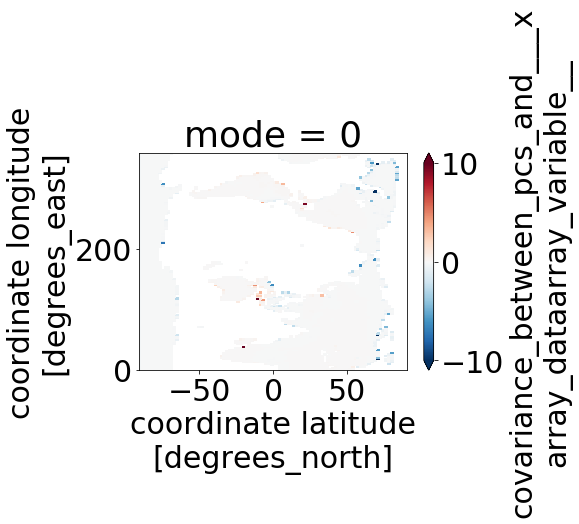

In [72]:
eof1[0,:,:].plot(vmax=10)

In [35]:
scaling_factor=1/(eofs[:,:,0]).mean(dim=['lat','lon'])

In [36]:
((eofs[:,:,0])/landweights*scaling_factor).mean(dim=['lat','lon'])

<xarray.DataArray ()>
array(0.43062377)
Coordinates:
    mode     int64 0

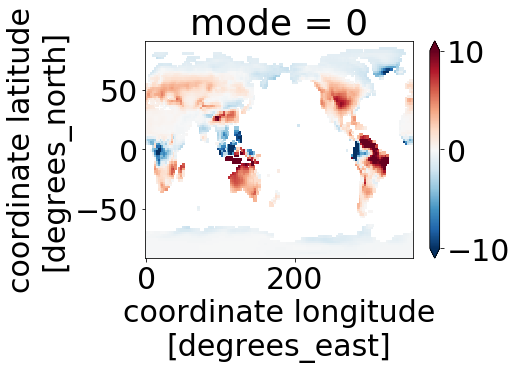

In [48]:
((eofs[:,:,0])*scaling_factor/landweights).plot(vmax=10)

/glade/u/home/czarakas/coupled_PPE/code/utils/quick_map.py:82: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cbar.set_clim(clim)


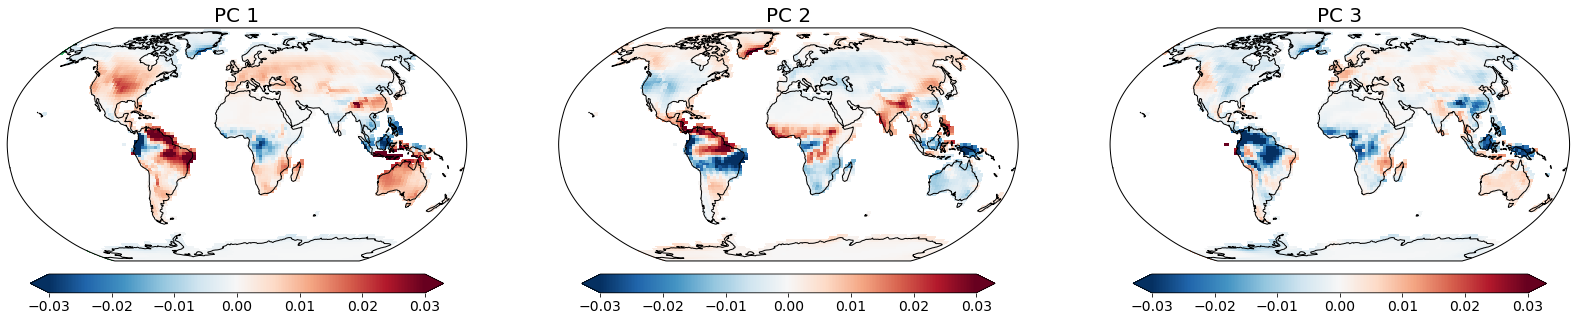

In [37]:
lats = eofs['lat'].values
lons = eofs['lon'].values
fig = plt.figure(figsize=(28, 12))
for i in range(0,3):
    quick_map.quick_map_subplot(((eofs[:,:,i])/landweights).values,lats,lons, nrow=1, ncol=3, ind=i,
                                clim=[-0.03,0.03], cmap=plt.cm.RdBu_r,
                                title='PC '+str(i+1))
plt.savefig(var+'_PCs.png')

# In EOF space 

0.6873779651999814
0.20710474553354918


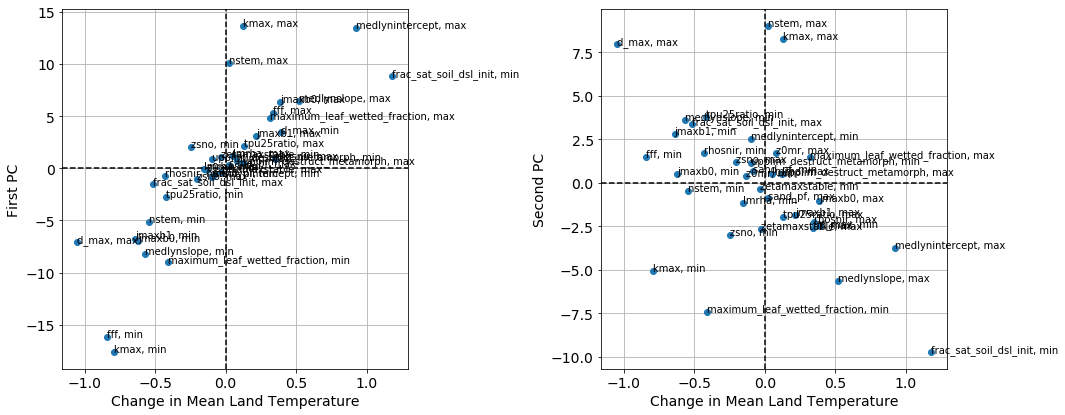

In [103]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
x=delta_land_Ts
y=pcs[:,0]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value*r_value)
plt.plot(x, y,'o')
for i in np.arange(0,36):
    plt.text(x[i],y[i],data_descriptions[i], fontsize=10)
plt.grid()
plt.axhline(y=0, linestyle='--',color='k')
plt.axvline(x=0, linestyle='--',color='k')
plt.xlabel('Change in Mean Land Temperature')
plt.ylabel('First PC')

plt.subplot(1,2,2)
x=delta_land_Ts
y=pcs[:,1]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value*r_value)
plt.plot(x, y,'o')
for i in np.arange(0,36):
    plt.text(x[i],y[i],data_descriptions[i], fontsize=10)
plt.grid()
plt.axhline(y=0, linestyle='--',color='k')
plt.axvline(x=0, linestyle='--',color='k')
plt.xlabel('Change in Mean Land Temperature')
plt.ylabel('Second PC')

plt.tight_layout()

0.2969324483969453
0.5656816790818558


Text(0, 0.5, 'Loading PC1')

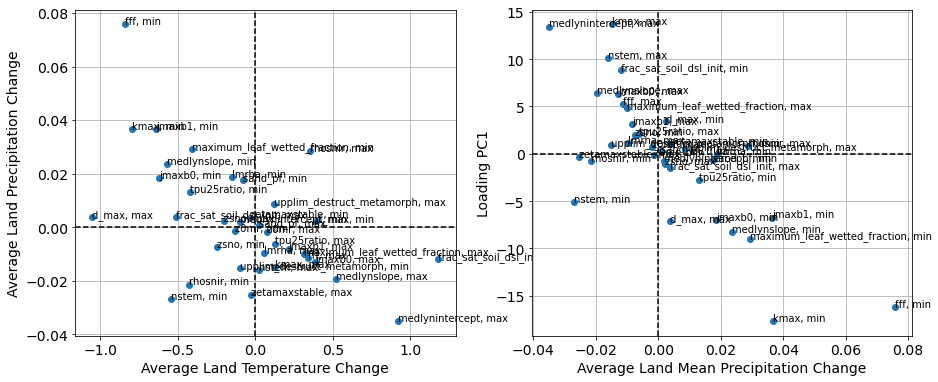

In [155]:
plt.rcParams.update({'font.size': 14})
plot_text=True

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
x=delta_land_Ts#(var_array*landweights).mean(dim=['lat','lon'])
y=delta_land_PRECT*86400
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value*r_value)

plt.plot(x, y,'o')
if plot_text:
    for i in np.arange(0,36):
        plt.text(x[i],y[i],data_descriptions[i], fontsize=10)
plt.grid()
plt.axhline(y=0, linestyle='--',color='k')
plt.axvline(x=0, linestyle='--',color='k')
plt.xlabel('Average Land Temperature Change')
plt.ylabel('Average Land Precipitation Change')

plt.subplot(1,2,2)
x=delta_land_PRECT*86400#(var_array*landweights).mean(dim=['lat','lon'])
y=pcs[:,0]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value*r_value)

plt.plot(x, y,'o')
if plot_text:
    for i in np.arange(0,36):
        plt.text(x[i],y[i],data_descriptions[i], fontsize=10)
plt.grid()
plt.axhline(y=0, linestyle='--',color='k')
plt.axvline(x=0, linestyle='--',color='k')
plt.xlabel('Average Land Mean Precipitation Change')
plt.ylabel('Loading PC1')

0.5656816790818557


Text(0, 0.5, 'Loading PC1')

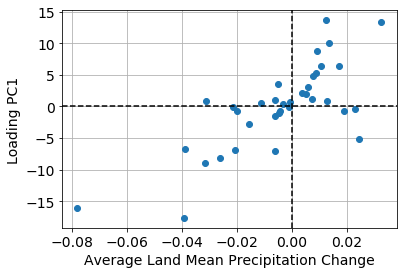

In [56]:
plt.rcParams.update({'font.size': 14})
plot_text=True

x=(var_array*landweights).mean(dim=['lat','lon'])
y=pcs[:,0]

plt.plot(x, y,'o')
if plot_text:
    for i in np.arange(0,36):
        1#plt.text(x[i],y[i],data_descriptions[i], fontsize=10)
plt.grid()
plt.axhline(y=0, linestyle='--',color='k')
plt.axvline(x=0, linestyle='--',color='k')
plt.xlabel('Average Land Mean Precipitation Change')
plt.ylabel('Loading PC1')

In [57]:
plt.rcParams.update({'font.size': 14})

In [58]:
descriptions=crosswalk.description.values

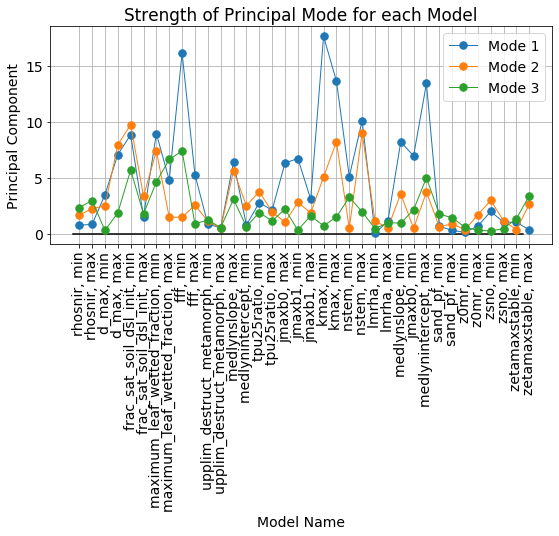

In [59]:
labels=descriptions#var_array.ensemble_key.values
fig = plt.figure(figsize=(9, 4))
plt.plot([0.5,np.size(labels)-0.5],[0,0],'-k')
for i in range(0,3):
    pcs_annual = np.abs(pcs[:,i])
    plt.plot(np.arange(1,np.size(pcs_annual['time'])+1),
             pcs_annual,label='Mode '+str(i+1),linewidth=1,marker='.',markersize=15)
    plt.xlabel('Model Name')
    plt.ylabel('Principal Component')
    plt.title('Strength of Principal Mode for each Model')
plt.legend()
#plt.xlim([0.5,np.size(labels)-0.5])
plt.xticks(np.arange(1,np.size(labels)+0.5,1),labels=labels, rotation=90)
plt.grid()
plt.savefig(var+'_strength_principal_mode_per_sim.png')

In [197]:
markerstyles=['o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'o',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'o',
             'o',
             'o',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v',
             'v']

In [198]:
fillstyles=['none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'full',
             'none',
             'none',
             'full',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
            'none',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
             'none',
             'full',
           'none']

In [199]:
colors=['tab:blue',
             'tab:blue',
             'tab:orange',
             'tab:orange',
             'tab:green',
             'tab:green',
             'tab:red',
             'tab:red',
             'tab:purple',
             'tab:purple',
             'tab:brown',
             'tab:brown',
             'tab:pink', #WRONG
             'tab:olive', #WRONG
             'tab:cyan',
              'tab:cyan',
        'tab:gray',
            'tab:blue',
             'tab:blue',
             'tab:orange',
             'tab:orange',
             'tab:green',
             'tab:green',
             'tab:red',
             'tab:red',
             'tab:pink',
             'tab:gray',
             'tab:olive',
             'tab:pink',
             'tab:pink',
             'tab:cyan',
              'tab:cyan',
       'tab:gray',
       'tab:gray',
       'tab:olive',
        'tab:olive']

# Compare leading PC with global mean warming

In [200]:
global_mean_deltaT=[]
for m, modelname in enumerate(labels):
    deltaT_global=(deltaT_normalized[:,:,m]*landweights).mean(dim=['lat','lon']).values
    global_mean_deltaT.append(deltaT_global)

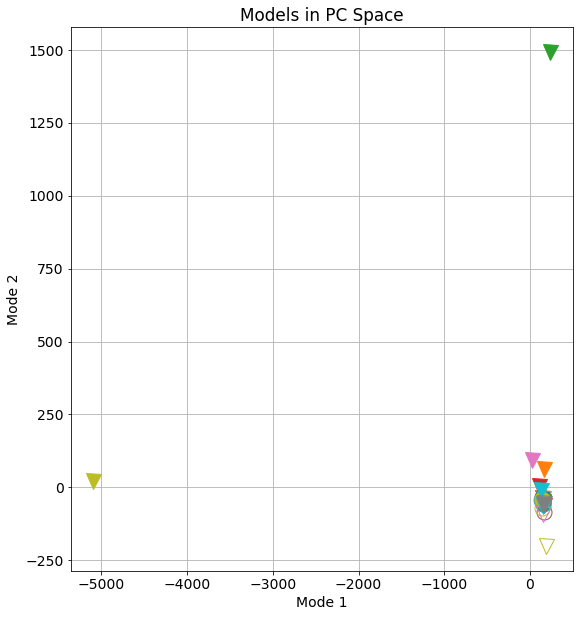

In [201]:
fig = plt.figure(figsize=(9, 10))
#plt.plot([-500,170],[0,0],'-k')
#plt.plot([0,0],[-175,150],'-k')
pc1 = (pcs[:,0].values)
pc2 = (pcs[:,1].values)
for m, modelname in enumerate(labels):
    if m%2==0:
        fillstyle='none'
    else:
        fillstyle='full'
    plt.plot(-pc1[m], pc2[m],markerstyles[m],color=colors[m],fillstyle=fillstyles[m],
             linewidth=0,markersize=15, label=modelname)
    #plt.plot(-pc1[m], pc2[m],markerstyles[m],'.,fillstyle=fillstyles[m],
    #         linewidth=0,markersize=15, label=modelname)
    #plt.annotate(modelname, [-pc1[m]+0.0002, pc2[m]-0.0001])
plt.xlabel('Mode 1')
plt.ylabel('Mode 2')
plt.title('Models in PC Space')
#plt.legend(fontsize=8, ncol=3)
#plt.xlim([-0.009,0.007])
#plt.ylim([-0.009,0.007])
#plt.ylim([-20,70])
plt.grid()
#plt.legend(ncol=3, fontsize=11)
plt.savefig(var+'_PC1vsPC2_projection.png')

# Bar chart

In [202]:
crosswalk['PCmode1']=np.nan
pc0=pcs[:,0]

for i, desc in enumerate(var_array.ensemble_key.values):
    crosswalk['PCmode1'][i+1]=pc1[i]

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [203]:
params=['frac_sat_soil_dsl_init','d_max', 'fff','sand_pf',
        'upplim_destruct_metamorph', 'z0mr', 'zetamaxstable', 'zsno',
        'medlynintercept','kmax','medlynslope',
        'jmaxb0', 'jmaxb1', 'tpu25ratio',
        'rhosnir',
        'lmrha',
        'nstem','maximum_leaf_wetted_fraction']
param_colors=['blue','blue', 'blue','blue',
        'purple', 'purple', 'purple', 'purple',
        'forestgreen', 'forestgreen', 'forestgreen',
        'lightseagreen', 'lightseagreen','lightseagreen',
              'goldenrod',
              'lightgreen',
        'orange','orange']

(-1, 18)

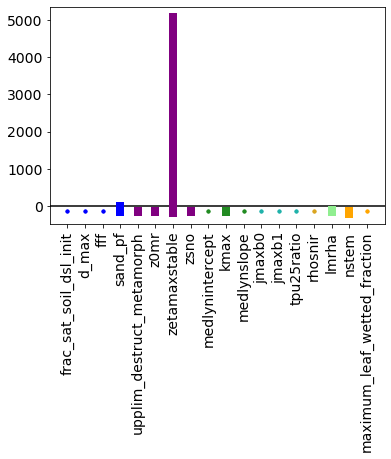

In [204]:
plt.rcParams.update({'font.size': 14})
plt.plot([-1,np.size(params)],[0,0],'-k')
for i, param in enumerate(params):
    minval=crosswalk['PCmode1'].values[crosswalk.description==param+', min']
    maxval=crosswalk['PCmode1'].values[crosswalk.description==param+', max']
    plt.plot([i,i], [minval,maxval],'.-', linewidth=8, color=param_colors[i])

plt.xticks(np.arange(0, i+1), params, rotation='vertical')
plt.xlim([-1,np.size(params)])